In [54]:
import numpy as np
import pandas as pd
import torch
from importlib.metadata import version
import re
import tiktoken
from torch.utils.data import Dataset, DataLoader
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import os

# Make the local src directory importable, then import the class by module name
sys.path.append(os.path.abspath("../src"))
from MultiHeadAttention import MultiHeadAttention
from GPTDatasetV1 import GPTDatasetV1, create_dataloader_v1

In [55]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) 
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [56]:
linear_layer = nn.Linear(5, 6)
relu = torch.nn.ReLU()

output = relu(linear_layer(batch_example))
output

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [57]:
print("before mean:", batch_example.mean(dim=1))
print("before variance:", batch_example.var(dim=1, unbiased=False))
print("after mean:", output.mean(dim=1))
print("after variance:", output.var(dim=1, unbiased=False))

before mean: tensor([-0.3596, -0.2606])
before variance: tensor([0.2015, 0.2673])
after mean: tensor([0.1324, 0.2170], grad_fn=<MeanBackward1>)
after variance: tensor([0.0192, 0.0332], grad_fn=<VarBackward0>)


In [58]:
means = output.mean(dim=-1, keepdim=True)  # Shape: (2, 1)
variances = output.var(dim=-1, keepdim=True, unbiased=False)  # Shape: (2, 1)

# Normalize the output
normalized = (output - means) / torch.sqrt(variances)
normalized

tensor([[ 0.6746,  1.5474, -0.9551,  0.6433, -0.9551, -0.9551],
        [-0.0207,  0.1228, -1.1915,  1.6621,  0.6186, -1.1915]],
       grad_fn=<DivBackward0>)

In [59]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))  # Vecteur d'échelle entraînable
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # Vecteur de décalage entraînable

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)  # Moyenne par ligne (batch)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)  # Variance par ligne (batch)
        output = self.scale * ((x - mean) / (torch.sqrt(variance) + self.eps)) + self.shift
        return output

In [60]:
layer = LayerNorm(6)
layer(output)

tensor([[ 0.6746,  1.5473, -0.9550,  0.6432, -0.9550, -0.9550],
        [-0.0207,  0.1228, -1.1914,  1.6620,  0.6186, -1.1914]],
       grad_fn=<AddBackward0>)

In [61]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

In [62]:
x = np.linspace(-3, 3, 100)
gelu = GELU()
res = gelu(x)
res

array([-0.00363739, -0.00440045, -0.00529646, -0.00634288, -0.00755835,
       -0.00896261, -0.0105763 , -0.01242081, -0.01451794, -0.01688963,
       -0.01955758, -0.02254274, -0.0258649 , -0.02954203, -0.03358971,
       -0.03802041, -0.04284278, -0.04806086, -0.05367328, -0.05967239,
       -0.06604349, -0.07276394, -0.0798024 , -0.08711809, -0.09466008,
       -0.10236674, -0.11016528, -0.11797143, -0.12568929, -0.1332114 ,
       -0.14041896, -0.14718231, -0.15336166, -0.15880801, -0.16336438,
       -0.1668672 , -0.16914798, -0.17003514, -0.16935606, -0.1669392 ,
       -0.16261643, -0.15622527, -0.14761129, -0.13663037, -0.12315087,
       -0.10705576, -0.08824439, -0.06663421, -0.04216206, -0.01478523,
        0.0155178 ,  0.04874703,  0.08488094,  0.12387682,  0.16567152,
        0.21018246,  0.25730903,  0.30693416,  0.35892624,  0.41314115,
        0.46942443,  0.52761364,  0.58754062,  0.64903384,  0.71192068,
        0.77602956,  0.84119199,  0.9072444 ,  0.97402981,  1.04

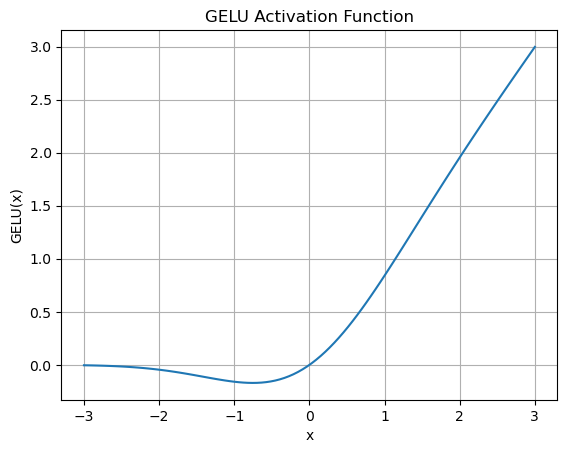

In [63]:
plt.plot(x, res)
plt.xlabel('x')
plt.ylabel('GELU(x)')
plt.title('GELU Activation Function')
plt.grid(True)
plt.show()

In [64]:
class RELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.clamp(x, min=0)

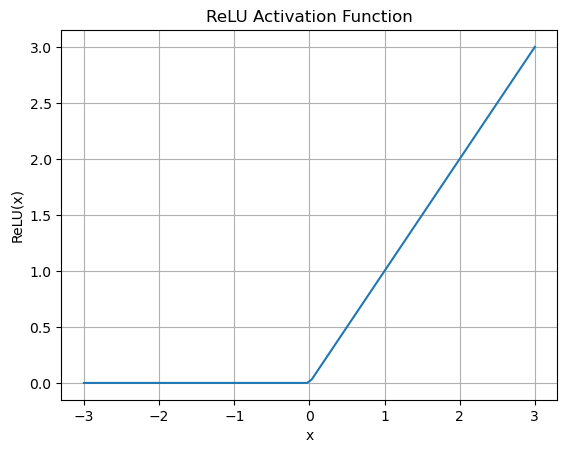

In [65]:
x = np.linspace(-3, 3, 100)
res = np.maximum(0, x)  # NumPy ReLU

plt.plot(x, res)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU Activation Function')
plt.grid(True)
plt.show()

In [66]:
class FeedForward(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.layer1 = nn.Linear(emb_size, 4*emb_size)
        self.gelu = nn.GELU()
        self.layer2 = nn.Linear(4*emb_size, emb_size)

    def forward(self, x):
        return self.layer2(self.gelu(self.layer1(x)))

In [67]:
input = torch.randn(2, 6) 
input

tensor([[-0.7291, -0.1218, -0.4796, -0.5166, -0.3107,  0.2057],
        [ 0.9657,  0.7057,  0.7290,  1.2775, -1.0815, -1.3027]])

In [68]:
ff = FeedForward(6)
ff(input)

tensor([[ 0.0424, -0.0082, -0.0421, -0.1347, -0.1421,  0.0695],
        [ 0.0246,  0.1826, -0.1126, -0.1857, -0.2609,  0.3002]],
       grad_fn=<AddmmBackward0>)

In [69]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, use_shortcut=False):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.sequential = nn.Sequential(
            nn.Linear(3, 3),
            nn.GELU(),
            nn.Linear(3, 3),
            nn.GELU(),
            nn.Linear(3, 3),
            nn.GELU(),
            nn.Linear(3, 3),
            nn.GELU(),
            nn.Linear(3, 1),
            nn.GELU()
        )

    def forward(self, x):
        if not self.use_shortcut:
            return self.sequential(x)
        else:
            # Appliquer les couches une par une pour ajouter les résidus
            x1 = self.sequential[0](x)
            x1 = self.sequential[1](x1)
            if x1.shape == x.shape:
                x1 = x1 + x

            x2 = self.sequential[2](x1)
            x2 = self.sequential[3](x2)
            if x2.shape == x1.shape:
                x2 = x2 + x1

            x3 = self.sequential[4](x2)
            x3 = self.sequential[5](x3)
            if x3.shape == x2.shape:
                x3 = x3 + x2

            x4 = self.sequential[6](x3)
            x4 = self.sequential[7](x4)
            if x4.shape == x3.shape:
                x4 = x4 + x3

            # Dernière couche (pas de résidu)
            out = self.sequential[8](x4)
            out = self.sequential[9](out)
            return out

In [70]:
torch.manual_seed(123)
input = torch.Tensor([1., 0., -1.])

network = ExampleDeepNeuralNetwork(False)
res = network(input)
res

tensor([0.0610], grad_fn=<GeluBackward0>)

In [71]:
target = torch.tensor([0.])

loss_fn = nn.MSELoss()
loss = loss_fn(res, target)

print("Sortie du réseau :", res)
print("Perte (MSE) :", loss)

Sortie du réseau : tensor([0.0610], grad_fn=<GeluBackward0>)
Perte (MSE) : tensor(0.0037, grad_fn=<MseLossBackward0>)


In [72]:
network.zero_grad()

loss.backward()

for name, param in network.named_parameters():
    if param.grad is not None:
        mean_abs_grad = torch.mean(torch.abs(param.grad))
        print(f"Layer: {name} | Mean of absolute gradients: {mean_abs_grad:.6f}")
    else:
        print(f"Layer: {name} | No gradients")

Layer: sequential.0.weight | Mean of absolute gradients: 0.000202
Layer: sequential.0.bias | Mean of absolute gradients: 0.000303
Layer: sequential.2.weight | Mean of absolute gradients: 0.000120
Layer: sequential.2.bias | Mean of absolute gradients: 0.000844
Layer: sequential.4.weight | Mean of absolute gradients: 0.000715
Layer: sequential.4.bias | Mean of absolute gradients: 0.003960
Layer: sequential.6.weight | Mean of absolute gradients: 0.001399
Layer: sequential.6.bias | Mean of absolute gradients: 0.012068
Layer: sequential.8.weight | Mean of absolute gradients: 0.005050
Layer: sequential.8.bias | Mean of absolute gradients: 0.071868


In [73]:
network = ExampleDeepNeuralNetwork(True)
res = network(input)
print(res)

loss = loss_fn(res, target)

print("Sortie du réseau :", res)
print("Perte (MSE) :", loss)

network.zero_grad()

loss.backward()

for name, param in network.named_parameters():
    if param.grad is not None:
        mean_abs_grad = torch.mean(torch.abs(param.grad))
        print(f"Layer: {name} | Mean of absolute gradients: {mean_abs_grad:.6f}")
    else:
        print(f"Layer: {name} | No gradients")

tensor([0.0267], grad_fn=<GeluBackward0>)
Sortie du réseau : tensor([0.0267], grad_fn=<GeluBackward0>)
Perte (MSE) : tensor(0.0007, grad_fn=<MseLossBackward0>)
Layer: sequential.0.weight | Mean of absolute gradients: 0.001434
Layer: sequential.0.bias | Mean of absolute gradients: 0.002150
Layer: sequential.2.weight | Mean of absolute gradients: 0.004820
Layer: sequential.2.bias | Mean of absolute gradients: 0.005248
Layer: sequential.4.weight | Mean of absolute gradients: 0.004116
Layer: sequential.4.bias | Mean of absolute gradients: 0.007933
Layer: sequential.6.weight | Mean of absolute gradients: 0.005884
Layer: sequential.6.bias | Mean of absolute gradients: 0.009100
Layer: sequential.8.weight | Mean of absolute gradients: 0.032492
Layer: sequential.8.bias | Mean of absolute gradients: 0.028929


In [74]:
class ResidualConnections(nn.Module):
    def __init__(self, emb_dim, use_shortcut=False):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.sequential = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x):
        if not self.use_shortcut:
            return self.sequential(x)
        else:
            # Appliquer les couches une par une pour ajouter les résidus
            x1 = self.sequential[0](x)
            x1 = self.sequential[1](x1)
            x1 = x1 + x
            x2 = self.sequential[2](x1)
            x2 = self.sequential[3](x2)
            x2 = x2 + x1
            x3 = self.sequential[4](x2)
            x3 = self.sequential[5](x3)
            x3 = x3 + x2
            x4 = self.sequential[6](x3)
            x4 = self.sequential[7](x4)
            x4 = x4 + x3
            # Dernière couche
            out = self.sequential[8](x4)
            return out

In [75]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config["vocab_size"]
        self.context_length = config["context_length"]
        self.emb_dim = config["emb_dim"]
        self.n_heads = config["n_heads"]
        self.n_layers = config["n_layers"]
        self.drop_rate = config["drop_rate"]
        self.qkv_bias = config["qkv_bias"]

        self.layerNorm1 = LayerNorm(self.emb_dim)
        self.mha = MultiHeadAttention(self.emb_dim, self.emb_dim, self.n_heads, self.drop_rate)
        self.dropout1 = nn.Dropout(self.drop_rate)
        
        self.layerNorm2 = LayerNorm(self.emb_dim)
        self.feedForward = FeedForward(self.emb_dim)
        self.dropout2 = nn.Dropout(self.drop_rate)

    def forward(self, x):
        # First residual block: Multi-Head Attention
        shortcut = x
        x = self.layerNorm1(x)
        x = self.mha(x)
        x = self.dropout1(x)
        x = x + shortcut  # Residual connection
        
        # Second residual block: Feed Forward
        shortcut = x
        x = self.layerNorm2(x)
        x = self.feedForward(x)
        x = self.dropout2(x)
        x = x + shortcut  # Residual connection
        
        return x

In [79]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

torch.manual_seed(123)

transformer = TransformerBlock(GPT_CONFIG_124M)

input = torch.rand(2, 4, 768)
res = transformer(input)
print(res.shape)
print(res)

torch.Size([2, 4, 768])
tensor([[[ 0.3260,  0.0638,  0.6306,  ...,  0.9430,  1.5904,  1.7416],
         [-0.0150,  0.9118,  1.0550,  ...,  0.7379,  0.4352,  1.8379],
         [-0.7378,  0.2423,  0.8163,  ...,  1.0726,  0.6950,  0.4585],
         [ 0.3665,  0.4930,  0.3940,  ...,  0.1075,  0.4033,  0.6233]],

        [[ 0.8960,  1.0967,  0.7262,  ...,  0.0076,  0.5391,  1.2215],
         [ 0.6338,  0.7058,  0.8105,  ...,  0.2267,  0.7184,  0.6841],
         [ 0.6277,  0.6638,  0.6010,  ...,  0.4773,  0.7491,  0.7075],
         [ 0.4729,  0.4645,  0.7552,  ...,  0.2722,  0.8397,  1.3290]]],
       grad_fn=<AddBackward0>)


In [ ]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config["vocab_size"]
        self.context_length = config["context_length"]
        self.emb_dim = config["emb_dim"]
        self.n_heads = config["n_heads"]
        self.n_layers = config["n_layers"]
        self.drop_rate = config["drop_rate"]
        self.qkv_bias = config["qkv_bias"]

        self.token_embedding = nn.Embedding(self.vocab_size, self.emb_dim) # 50257 * 768 = 38,605,056
        self.pos_embedding_layer = torch.nn.Embedding(self.context_length, self.emb_dim) # 1024 * 768 = 786,432

        self.dropout = nn.Dropout(self.drop_rate)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(config) for _ in range(self.n_layers)]) 
        # LayerNorm1 -> 2 * 768 = 1,536
        # qkv + out -> (3 * (768 * 768)) + (768 * 768) = 2,359,296
        # 2,359,296 * 12 = 28,311,552
        # LayerNorm2 -> 2 * 768 = 1,536
        # FeedForward -> 768 * (4 * 768) + (4 * 768) * 768 = 4,718,592

        self.layerNorm = LayerNorm(self.emb_dim) # 2 * 768 = 1,536

        self.inverseEmbedding = nn.Linear(self.emb_dim, self.vocab_size, bias=False) # 768 * 50257 = 38,605,056

    def forward(self, x):
        # x: (batch_size, context_length)
        batch_size, seq_len = x.shape

        token_embeddings = self.token_embedding(x)

        pos_embeddings = self.pos_embedding_layer(torch.arange(seq_len, device=x.device))  # (seq_len, emb_dim)
        pos_embeddings = pos_embeddings.unsqueeze(0)  # (1, seq_len, emb_dim)

        x = token_embeddings + pos_embeddings
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.layerNorm(x)

        logits = self.inverseEmbedding(x)
        
        return logits

In [80]:
torch.manual_seed(123)

gptModel = GPTModel(GPT_CONFIG_124M)
batch = torch.tensor([
    [6109, 3626, 6100,  345],
    [6109, 1110, 6622,  257]
], dtype=torch.long)

output = gptModel(batch)
print(output.shape)
print(output)

torch.Size([2, 4, 50257])
tensor([[[-0.6273, -0.1459,  0.1839,  ..., -0.6657, -0.4855, -0.7900],
         [-0.2751, -0.7954, -0.5569,  ...,  0.0810, -0.3879, -0.5015],
         [ 0.3020,  0.2730,  0.0179,  ...,  0.5005, -0.1498,  0.5616],
         [-0.3155, -0.1603,  1.1678,  ...,  0.5601,  0.3109,  0.3132]],

        [[-0.7104, -0.2001,  0.0363,  ..., -0.2801, -0.5356, -0.6127],
         [-0.5182, -0.4020, -0.4059,  ..., -0.6950, -0.7436, -0.0123],
         [ 0.5662, -0.0498,  0.4945,  ..., -0.3452, -0.3019,  0.3400],
         [-0.1737, -0.5376,  0.7940,  ...,  0.7630,  0.3292,  0.2092]]],
       grad_fn=<UnsafeViewBackward0>)


In [88]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(gptModel)
print(f"Total number of parameters : {total_params:,}")

Total number of parameters : 163,000,320
